まず活性化関数や二項演算子を定義する．

In [2]:
name_activation = ["identity", "tanh", "sign", "ReLU"] # 恒等関数のみ
activation = {} # これが活性化関数を表すことになる

def identity(x):
    return x
activation["identity"] = identity

def tanh(x):
    return np.tanh(x)
activation["tanh"] = tanh

def exp(x):
    return np.exp(x)
#activation["exp"] = exp

def sign(x):
    return (x > 0.0)*1.0
activation["sign"] = sign

def ReLU(x):
    return sign(x)*x
activation["ReLU"] = ReLU


name_binary_operator = ["sum", "x_times_y", "unary_x", "max", "min"]
binary_operator = {} # binary operatorも同様
binary_operator["max"] = max
binary_operator["min"] = min

def sum(x,y):
    return x+y
binary_operator["sum"] = sum

def diff(x,y):
    return x-y
#binary_operator["diff"] = diff

def x_times_y(x,y):
    return x*y
binary_operator["x_times_y"] = x_times_y

def unary_x(x,y):
    return x
binary_operator["unary_x"] = unary_x

def unary_y(x,y):
    return y
#binary_operator["unary_y"] = unary_y

def x_is_greater_than_y(x,y):
    return (x > y)*1.0
#binary_operator["x_is_greater_than_y"] = x_is_greater_than_y

次にダイナミクスを定義する．$K$個の変数があり，ダイナミクスは
$$
y_0(t+1) = 0.5y_0(t)  - 0.5y_0(t)y_1(t) + 0.1\min(y_0(t), y_1(t)) + \epsilon_0(t) \\
y_1(t+1) = -0.2y_0(t) + 0.8y_1(t) + 0.5\max(y_0(t), y_1(t)) + \epsilon_1(t)
$$
であるものとする．
ただし$\epsilon_i(t)$は正規分布に従う独立な乱数とする．

まずはデータを生成する．

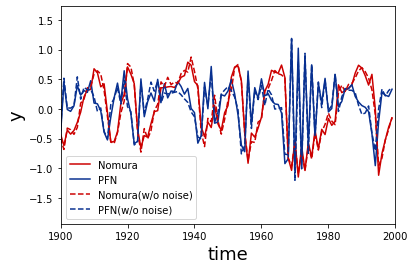

In [99]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sigma_true = 0.1 # 真のデータに生じるノイズの大きさ，dynamicsの引数sigmaと区別するために名前を付けている．

def dynamics(y_t, sigma): # 次の時刻における変数の値を返す関数
    y_next = np.zeros(2)
    y_next[0] = 1.0*tanh(y_t[0]) + 0.8*y_t[0]*y_t[1] + 1.0*y_t[1] - 1.0*ReLU(min(y_t[0], y_t[1])) + sigma*np.random.randn()
    y_next[1] = +0.6*sign(y_t[1]) + 0.5*y_t[0]*y_t[1] - 1.0*max(y_t[0], y_t[1]) + sigma*np.random.randn()
    return y_next

T_total = 2000 # トータルでのタイムステップ．
y = np.zeros((2, T_total))
y_without_noise = np.zeros((2, T_total)) # ノイズがない場合の時間発展．ダイナミクスを完全に再現できた場合，このように時間発展するはず．

y[:,0] = np.array([0.5, 0.5])
y_without_noise[:,0] = np.array([0.5, -0.5])

for t in range(1, T_total):
    #print(y[:,t-1])
    y[:,t] = dynamics(y[:,t-1], sigma_true)
    y_without_noise[:,t] = dynamics(y[:,t-1], 0.0)


name_stock = ["Nomura", "PFN"] # 天気予報の時の名残なので気にしなくてよい
num_stock = len(name_stock)

plt.xlim([T_total-100,T_total])
plt.plot(y[0], color = "#cc0000", label = name_stock[0])
plt.plot(y[1], color = "#083090", label = name_stock[1])
plt.plot(y_without_noise[0], color = "#cc0000", linestyle = "--", label = name_stock[0] + "(w/o noise)")
plt.plot(y_without_noise[1], color = "#083090", linestyle = "--", label = name_stock[1] + "(w/o noise)")
plt.xlabel("time", fontsize = 18)
plt.ylabel("y", fontsize = 18)
plt.legend()
plt.savefig("Nomura_PFN.pdf")



活性化関数とbinary operatorを辞書型で定義する．なお，簡単のために活性化関数は恒等関数のみ，binary operatorもいくつかに限って実装．

以下で`Trader`の定義をする．なお，論文と同様にtime_windowを導入し，その範囲のデータしかtrainに使えないものとする．

In [100]:
time_window = 100
delay_max = 2
class Trader:
    def __init__(self, num_factors_max = 4, delay_max = 2): # num_factor_maxはformulaに含まれる項の最大値，delay_maxはどれだけ過去のデータを用いることができるか
        self.num_factors_max = num_factors_max
        self.delay_max = delay_max

        self.num_factors = [[] for _ in range(num_stock)] # Traderは予測したい都市(target)ごとに異なる式を用いるため，targetごとに項の数も異なる．
        self.delay_x = [[] for _ in range(num_stock)]
        self.delay_y = [[] for _ in range(num_stock)]
        self.stock1 = [[] for _ in range(num_stock)]
        self.stock2 = [[] for _ in range(num_stock)]
        self.w = [[] for _ in range(num_stock)]
        self.activation = [[] for _ in range(num_stock)]
        self.binary_operator = [[] for _ in range(num_stock)]
        self.X_factor = [[] for _ in range(num_stock)]
        self.cumulative_error = [[] for _ in range(num_stock)]

        for target in range(num_stock):
            self.num_factors[target] = np.random.choice(range(1, self.num_factors_max+1))

            self.delay_x[target] = np.random.choice(delay_max, self.num_factors[target])
            self.delay_y[target] = np.random.choice(delay_max, self.num_factors[target])

            self.stock1[target] = [np.random.choice(num_stock) for _ in range(self.num_factors[target])]
            self.stock2[target] = [np.random.choice(num_stock) for _ in range(self.num_factors[target])]

            self.activation[target] = [np.random.choice(name_activation) for _ in range(self.num_factors[target])]
            self.binary_operator[target] = np.random.choice(name_binary_operator, self.num_factors[target])

            self.w[target] = np.random.randn(self.num_factors[target])
            self.X_factor[target] = np.zeros((0, self.num_factors[target]))

            self.cumulative_error[target] = 0.0

    def reset_parameters(self, target): # ファクターの行列Xがランク落ちした際に必要
        self.num_factors[target] = np.random.choice(range(1, self.num_factors_max+1))

        self.delay_x[target] = np.random.choice(delay_max, self.num_factors[target])
        self.delay_y[target] = np.random.choice(delay_max, self.num_factors[target])

        self.stock1[target] = [np.random.choice(num_stock) for _ in range(self.num_factors[target])]
        self.stock2[target] = [np.random.choice(num_stock) for _ in range(self.num_factors[target])]

        self.activation[target] = [np.random.choice(name_activation) for _ in range(self.num_factors[target])]
        self.binary_operator[target] = np.random.choice(name_binary_operator, self.num_factors[target])
        self.w[target] = np.random.randn(self.num_factors[target])
        self.X_factor[target] = np.zeros((0, self.num_factors[target]))

        self.cumulative_error[target] = 0.0


    def calc_factor(self, target, j, data): # traderが持つ，targetに対するj番目のファクターを計算
        A = activation[self.activation[target][j]] # 可読性のため代入，以下同様
        O = binary_operator[self.binary_operator[target][j]]
        P = self.stock1[target][j]
        Q = self.stock2[target][j]
        D = self.delay_x[target][j]
        F = self.delay_y[target][j]
        return A(O(data[P][self.delay_max-D], data[Q][self.delay_max-F])) # 論文の式と対応している形

    def stack_factors(self, data_to_stack, target): # Companyのメソッドeducationのために必要なデータをstackしておく
        factors = np.zeros(self.num_factors[target])
        for j in range(self.num_factors[target]): # 各ファクターごとに
            factors[j] = self.calc_factor(target, j, data_to_stack)
        if len(self.X_factor[target]) < time_window: # time_windowよりもデータがたまっていないときは，ただ下に積むだけ．
            self.X_factor[target] = np.vstack([self.X_factor[target], factors])
        else: # time_windowよりもデータがたまっているときは，下に積みつつ過去のデータを消してしまう．
            self.X_factor[target] = np.roll(self.X_factor[target], -1, axis = 0)
            self.X_factor[target][-1] = factors

    # y = (y_{t-w-1}, , y_t)
    def learn(self, target, y): # 最小二乗法により，各ファクターの係数を最適化する．X_factorを使っていることに注意．
        epsilon = 0.0001 # singular matrixが生じないための工夫
        X = self.X_factor[target]
        if np.linalg.matrix_rank(X.T.dot(X) + epsilon) < self.num_factors[target]:
            #print("Note: rank(X_factor) < num_factors.")
            self.w[target] = np.zeros(len(self.w[target]))
        else:
            self.w[target] = np.linalg.inv(X.T.dot(X)+epsilon).dot(X.T).dot(y) # 最小二乗法で係数を求めている

    # prediction.shape = (num_stock, time_window)
    def predict_for_train(self): # train dataに対するprediction, これに基づいてcumulative_errorを計算し，bad_traderを解雇する．
        prediction = np.zeros((num_stock, time_window)) # 過去のデータに対して行うため，prediction.shape = (num_stock, time_window)
        for target in range(num_stock):
            prediction[target] = self.X_factor[target].dot(self.w[target])
        return prediction

    def predict_for_test(self): # test dataに対するprediction, これに基づいてモデルの評価を行う．
        prediction = np.zeros(num_stock) # 各時刻に対して行うため，prediction.shape  (num_stock)
        for target in range(num_stock):
            prediction[target] = self.X_factor[target][-1].dot(self.w[target])
        return prediction

    def calc_cumulative_error(self, y_true): # 過去のデータに対してcumulative_errorを計算，これに基づいてbad_traderを見つける．
        prediction = self.predict_for_train() # prediction.shape = (num_stock, time_window)
        errors = (prediction - y_true)**2.0
        errors = np.sqrt(errors.mean(1)) # errorsを時間軸方向について平均
        for target in range(num_stock):
            self.cumulative_error[target] = errors[target]


次に`Company`の定義をする．

In [101]:
class Company:
    def __init__(self, num_traders, Q = 0.2): # time_window shold be larger than num_factors_max
        self.Q = Q # 1-Qがbad_tradersの割合を表す，つまりQが大きいほど解雇される割合が少なくなる．Qは生存率ともいえる．

        self.traders = [[] for _ in range(num_traders)]
        for n in range(num_traders):
            self.traders[n] = Trader() # 適当にtraderを生成すると同じ意味を持つファクターを持つ可能性があるため，ランク落ちの問題が生じる．
            for target in range(num_stock): # 以下の手続きでランク落ちを回避
                self.generate_trader_without_singular(n, target, len(y[0]), y) # yがグローバル変数になってるけど許して
        self.num_traders = num_traders
        self.bad_traders = np.ones((num_stock, num_traders)) > 0.0 # とりあえず全員をbad_traderにしてみた，意味はない

    def educate(self, t): # 簡単のために，全トレーダーがeducateされるものとする(論文とは異なることに注意)
        for n in range(self.num_traders):
            for target in range(num_stock):
                y_true = y[target][t-time_window+1:t+1]
                self.traders[n].learn(target, y_true) # 最小二乗法により学習を行う．学習に必要なinputはstack_factorsで行っている．

    def find_bad_traders(self, y_true): # 過去のデータに基づいてself.bad_tradersを更新する，trainの最中にしか実行されないことに注意．
        cumulative_errors = np.zeros((num_stock, self.num_traders))
        for n in range(self.num_traders): # 各traderに対して
            for target in range(num_stock): # 各銘柄に対して
                self.traders[n].calc_cumulative_error(y_true) # cumulative_errorsを計算
                cumulative_errors[target][n] = self.traders[n].cumulative_error[target] # bad_tradersをQ-percentileを使って探すために必要

        for target in range(num_stock): # 各銘柄について，bad_tradersをQ-percentileを使って探す．
            self.bad_traders[target] = cumulative_errors[target] > np.percentile(cumulative_errors[target], 100.0*self.Q)

    def fire_and_recruit(self, t, y): # yは時刻tまでのデータ
        y_true = y[:,t-time_window+1:t+1]
        self.find_bad_traders(y_true) # self.bad_tradersのリストを更新
        for n in range(self.num_traders):
            for target in range(num_stock):
                if self.bad_traders[target][n]:
                    self.generate_trader_without_singular(n, target, t, y) # ランク落ちを回避しつつ生成，同時にX_factorも計算している
                    self.traders[n].calc_cumulative_error(y_true) # 次回のfind_bad_tradersのために，累積誤差を計算


    def generate_trader_without_singular(self, n, target, t, y): # ランク落ちを回避しつつ新しいTraderを生成
        self.traders[n] = Trader()
        for target in range(num_stock):
            for idx in reversed(range(time_window)):
                self.traders[n].stack_factors(y[:,t-delay_max-1-idx:t-idx], target) # X_factorを計算
            while np.linalg.matrix_rank(self.traders[n].X_factor[target].T.dot(self.traders[n].X_factor[target])) < self.traders[n].num_factors[target]:
                self.traders[n].reset_parameters(target) # rank落ちが発生していたらやり直し
                for idx in reversed(range(time_window)):
                    self.traders[n].stack_factors(y[:,t-delay_max-1-idx:t-idx], target)

    def aggregate(self): # Traderたちの意見を集める
        predictions = np.zeros((num_stock, self.num_traders))
        weights = np.zeros((num_stock, self.num_traders)) # Traderの意見を重みづけする

        for n in range(self.num_traders):
            for target in range(num_stock):
                if not self.bad_traders[target][n]: # Q-パーセンタイル以上の成績の良いTraderのみを対象
                    weights[target][n] = (1.0 / self.traders[n].cumulative_error[target]) # 重みは累積誤差の逆数，つまり誤差が少ないTraderほど重く見られる
                    predictions[target][n] = self.traders[n].predict_for_test()[target]
        predictions_weighted = np.zeros(num_stock)

        for target in range(num_stock):
            predictions_weighted[target] = (weights[target]*predictions[target]).sum() / (weights[target].sum())
        return predictions_weighted

    def observe(self, data_to_stack): # それ以前のデータを観測し，現時点のデータを予測するために利用する．
        for n in range(self.num_traders):
            for target in range(num_stock):
                self.traders[n].stack_factors(data_to_stack, target)


実際にアルゴリズムを動かす．

In [102]:
from tqdm import tqdm

model = Company(20)
errors_test = []

num_test_data = 200 # test dataのサイズ
T = T_total - num_test_data # train dataのサイズ

for t in tqdm(range(delay_max+1, len(y[0]))):
    data_to_stack = y[:,t-delay_max-1:t] # t-1までのデータであることに注意
    model.observe(data_to_stack) # train, testいずれの場合でもstackしなければならない

    # train or test
    if delay_max + 1 + time_window < t <= T: # train
        model.educate(t)
        model.fire_and_recruit(t, y)
    elif T < t: # test
        prediction_test = model.aggregate()
        errors_test.append(np.abs(y[:,t] - prediction_test))

100%|██████████████████████████████████████████████████████████████████████████████| 1997/1997 [04:27<00:00,  7.48it/s]


グラフにしたときに見やすいように，データを平滑化する．

In [103]:
# smoothing
errors_test = np.array(errors_test)
errors_test = errors_test.T
days_to_smooth = 5
errors_smoothed = np.zeros((len(errors_test), len(errors_test[0])+days_to_smooth-1))
ones_to_smooth = np.ones(days_to_smooth) / days_to_smooth
for idx in range(len(name_stock)):
    errors_smoothed[idx] = np.convolve(errors_test[idx], ones_to_smooth)
print(errors_smoothed.shape)
# base line method
errors_baseline = np.abs(y[:,T+1:] - y[:,T:-1])
errors_baseline_smoothed = np.zeros((len(errors_baseline), len(errors_baseline[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_baseline_smoothed[idx] = np.convolve(errors_baseline[idx], ones_to_smooth)


(2, 203)


Vector autoregression (VAR)との比較を行う．まずはVARの実装．

In [104]:
p = 1
y_train = y[:,0:T]
y_test = y[:,T:]
# train
Y = y_train[:,p:T]
Z = np.ones((len(y_train)*p+1, T-p))
for t in range(p):
    Z[1+t*len(y_train):1+t*len(y_train)+len(y_train):,:] = y[:,p-1-t:T-1-t]
B = Y.dot(Z.T).dot(np.linalg.inv(Z.dot(Z.T)))

# predict
Z = np.ones((len(y_test)*p+1, len(y_test[0])-p))
for t in range(p):
    Z[1+t*len(y_test):1+t*len(y_test)+len(y_test):,:] = y_test[:,p-1-t:len(y_test[0])-1-t]
y_VAR = B.dot(Z)

# errors
errors_VAR = np.abs(y[:,T+p:] - y_VAR)
errors_VAR_smoothed = np.zeros((len(errors_VAR), len(errors_VAR[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_VAR_smoothed[idx] = np.convolve(errors_VAR[idx], ones_to_smooth)

ベースラインや最適な予測も同様に平滑化し，グラフとして表示する．

(2, 208)


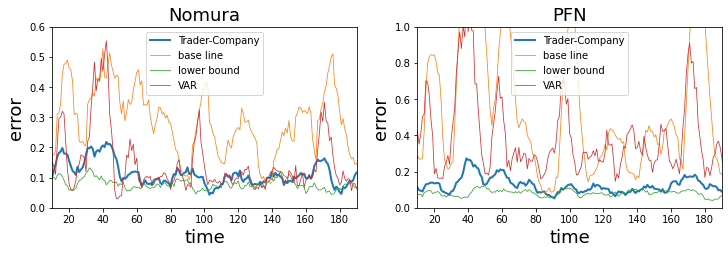

In [111]:
# smoothing
days_to_smooth = 10
errors_smoothed = np.zeros((len(errors_test), len(errors_test[0])+days_to_smooth-1))
ones_to_smooth = np.ones(days_to_smooth) / days_to_smooth
for idx in range(len(name_stock)):
    errors_smoothed[idx] = np.convolve(errors_test[idx], ones_to_smooth)
print(errors_smoothed.shape)
# base line method
errors_baseline = np.abs(y[:,T+1:] - y[:,T:-1])
errors_baseline_smoothed = np.zeros((len(errors_baseline), len(errors_baseline[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_baseline_smoothed[idx] = np.convolve(errors_baseline[idx], ones_to_smooth)

# lower bound
errors_lower_bound = np.abs(y[:,T+1:] - y_without_noise[:,T+1:])
errors_lower_bound_smoothed = np.zeros((len(errors_lower_bound), len(errors_lower_bound[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_lower_bound_smoothed[idx] = np.convolve(errors_lower_bound[idx], ones_to_smooth)

plt.figure(figsize=(12, 8)) # figureの縦横の大きさ
plt.subplots_adjust(wspace=0.2, hspace=0.4)

ymax = [0.6, 1.0]
for idx, name in enumerate(name_stock):
    plt.subplot(2,2,idx+1)
    plt.xlim([days_to_smooth, num_test_data - days_to_smooth])
    plt.ylim([0.0, ymax[idx]])
    plt.xlabel("time", fontsize = 18)
    plt.ylabel("error", fontsize = 18)
    plt.plot(errors_smoothed[idx], linewidth = 2.0, label = "Trader-Company")
    plt.plot(errors_baseline_smoothed[idx], linewidth = 0.75, label = "base line")
    plt.plot(errors_lower_bound_smoothed[idx], linewidth = 0.75, label = "lower bound")
    plt.plot(errors_VAR_smoothed[idx], linewidth = 0.75, label = "VAR")
    plt.title(name, fontsize = 18)
    plt.legend()
plt.savefig("Trader-Company.pdf")

各銘柄ごとにテストエラーの平均を比較．

In [113]:
T_temp = 200
for idx, name in enumerate(name_stock):
    print(name)
    print("baseline", errors_baseline[idx][0:T_temp].mean())
    print("VAR", errors_VAR[idx][0:T_temp].mean())
    print("Trader-Company", errors_test[idx][0:T_temp].mean())
    print("lower bound", errors_lower_bound[idx][0:T_temp].mean())

Nomura
baseline 0.28398306954974056
VAR 0.14264633981185523
Trader-Company 0.11435224032795732
lower bound 0.07829723753543665
PFN
baseline 0.5831486076288667
VAR 0.38117142931155035
Trader-Company 0.12445252617932831
lower bound 0.08135479901375332


最も成績の良いトレーダーの持つ活性化関数や二項演算子を確認する．

In [114]:
best_trader_for = [[], []]

for target in range(num_stock):
    error_min_temp = 2000.0 # 適当
    for n in range(model.num_traders):
        if model.traders[n].cumulative_error[target] < error_min_temp:
            best_trader_for[target] = n
            error_min_temp = model.traders[n].cumulative_error[target]

for target in range(num_stock):
    print("best trader for {0:} is {1:}".format(name_stock[target], best_trader_for[target]))
    print(model.traders[best_trader_for[target]].binary_operator[target])
    print(model.traders[best_trader_for[target]].activation[target])

best trader for Nomura is 11
['x_times_y' 'unary_x' 'x_times_y' 'unary_x']
['tanh', 'identity', 'ReLU', 'identity']
best trader for PFN is 11
['max' 'min' 'unary_x' 'max']
['identity', 'sign', 'sign', 'sign']


In [108]:
print(y)

[[ 0.5         0.59511404  0.64110906 ... -0.5212147  -0.30731247
  -0.15584624]
 [ 0.5         0.32657577  0.11485513 ...  0.23075152  0.20913675
   0.33153559]]
